In [1]:
import timm
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.decoders.unet.model import UnetDecoder
from segmentation_models_pytorch.decoders.unet.model import SegmentationHead
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import jaccard_score

import warnings
warnings.filterwarnings("ignore")


/opt/conda/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '.png'))


        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')


        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = SegmentationDataset("leaf_disease_segmentation/train_images", "leaf_disease_segmentation/train_masks", transform=data_transform)
val_dataset = SegmentationDataset("leaf_disease_segmentation/valid_images", "leaf_disease_segmentation/valid_masks", transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [3]:
# encoder_names = ["resnet34", "resnet50", "resnet101", "vgg16", "vgg19", "densenet121", "densenet169", "efficientnet-b0", "efficientnet-b1", "efficientnet-b2", "efficientnet-b3", "efficientnet-b4", "efficientnet-b5", "efficientnet-b6", "efficientnet-b7"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [4]:
def train_model(model, num_epochs, train_loader, val_loader, criterion, optimizer, model_save_path):
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

            val_loss /= len(val_loader)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss}")

            if val_loss < best_val_loss:
                print(f"Validation loss decreased from {best_val_loss:.4f} to {val_loss:.4f}, saving model...")
                torch.save(model.state_dict(), model_save_path)
                best_val_loss = val_loss

    model.load_state_dict(torch.load(model_save_path))
    return model


In [5]:
encoder_names = [ "resnet34","resnet101","vgg16","vgg19", "efficientnet-b0","efficientnet-b7"]
model_nets=["DeepLabV3","UNET","UNETplus"]
trained_models = {}
num_epochs=20

for encoder_name in encoder_names:
    for model_net in model_nets:
        print(f"Training {model_net} model with encoder {encoder_name}...")
        if model_net=="DeepLabV3" and "vgg" not in encoder_name:
            model = smp.DeepLabV3(
                encoder_name=encoder_name,
                encoder_weights="imagenet",
                in_channels=3,
                classes=1
            )
        elif model_net=="UNET":
            model = smp.Unet(
                encoder_name=encoder_name,
                encoder_weights="imagenet",
                in_channels=3,
                classes=1
            )
        elif model_net=="UNETplus":
            model = smp.UnetPlusPlus(
                encoder_name=encoder_name,
                encoder_weights="imagenet",
                in_channels=3,
                classes=1
            )
        else:
            continue
            
            
        for param in model.encoder.parameters():
            param.requires_grad = False

            # Modify the last layer for segmentation

        model = model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        model_save_path = f"{model_net}_{encoder_name}.pth"
        trained_model = train_model(model, num_epochs, train_loader, val_loader, criterion, optimizer, model_save_path)
        trained_models[model_net+encoder_name] = trained_model



Training DeepLabV3 model with encoder resnet34...
Epoch 1/20, Loss: 0.10937970876693726, Validation Loss: 0.09586981790406364
Validation loss decreased from inf to 0.0959, saving model...
Epoch 2/20, Loss: 0.10632428526878357, Validation Loss: 0.09366500351045813
Validation loss decreased from 0.0959 to 0.0937, saving model...
Epoch 3/20, Loss: 0.10592600703239441, Validation Loss: 0.09388567187956401
Epoch 4/20, Loss: 0.10698272287845612, Validation Loss: 0.09167201497725078
Validation loss decreased from 0.0937 to 0.0917, saving model...
Epoch 5/20, Loss: 0.10742658376693726, Validation Loss: 0.09252103364893369
Epoch 6/20, Loss: 0.1034507304430008, Validation Loss: 0.08995673832084451
Validation loss decreased from 0.0917 to 0.0900, saving model...
Epoch 7/20, Loss: 0.10377804934978485, Validation Loss: 0.0899627126221146
Epoch 8/20, Loss: 0.10568070411682129, Validation Loss: 0.09013927634805441
Epoch 9/20, Loss: 0.10423019528388977, Validation Loss: 0.08946704917720386
Validation 

In [6]:
# class ViTUnet(nn.Module):
#     def __init__(self, vit_model_name, num_classes):
#         super(ViTUnet, self).__init__()
#         self.vit = timm.create_model(vit_model_name, pretrained=True)
        
#         # self.decoder = UnetDecoder(
#         #     encoder_channels=(self.vit.head.in_features, 512, 256, 128, 64),
#         #     decoder_channels=(256, 128, 64, 32, 16),
#         #     final_channels=num_classes,
#         #     use_batchnorm=True
#         # )
#         self.decoder = UnetDecoder(in_channels=self.vit.head.in_features, out_channels=num_classes, use_batchnorm=True)
#         self.vit.head = nn.Identity()
#         self.segmentation_head = SegmentationHead(
#             in_channels=16,
#             out_channels=num_classes,
#             activation='sigmoid',
#             kernel_size=3
#         )

#     def forward(self, x):
#         features = self.vit(x)
#         x = self.decoder([features])
#         x = self.segmentation_head(x)
#         return x

# vit_model_names = ["vit_base_patch16_224", "vit_base_patch32_224", "vit_large_patch16_224", "vit_large_patch32_224"]
# for vit_model_name in vit_model_names:
#     print(f"Training model with Vision Transformer {vit_model_name}...")
#     model = ViTUnet(vit_model_name, num_classes=1)
#     model = model.to(device)
#     criterion = nn.BCEWithLogitsLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     model_save_path = f"unet_{vit_model_name}.pth"
#     trained_model = train_model(model, num_epochs, train_loader, val_loader, criterion, optimizer, model_save_path)
#     trained_models[vit_model_name] = trained_model


In [7]:


# model.load_state_dict(torch.load(model_save_path))
# model = model.to(device)
# model.eval()



def tensor_to_image(tensor):
    image = tensor.cpu().numpy().transpose((1, 2, 0))
    return (image * 255).astype(np.uint8)

def tensor_to_mask(tensor):
    mask = tensor.cpu().numpy().squeeze()
    # print(mask)
    return mask

def compute_scores(y_true, y_pred, threshold=0.1):
  
    y_true = (y_true > threshold).astype(np.uint8).flatten()
    y_pred = (y_pred > threshold).astype(np.uint8).flatten()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    iou=iou_score(y_true, y_pred)
    dice=dice_coefficient(y_true, y_pred)

    return accuracy,precision,recall,f1,iou,dice

def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union

def dice_coefficient(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    return (2 * intersection) / (y_true.sum() + y_pred.sum())

def evaluate_models(trained_models, val_loader, threshold):
    evaluation_results = {}
    
    for model_name, model in trained_models.items():
        model.eval()
        accuracies, precisions, recalls, f1_scores, ious, dice_coeffs = [], [], [], [], [], []

        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                preds = torch.sigmoid(model(images))

                preds = (preds > threshold).float()
                masks = (masks > threshold).float()


                accuracy,precision,recall,f1,iou,dice = compute_scores(masks.cpu().numpy(), preds.cpu().numpy(),threshold)
           
                accuracies.append(accuracy)
                precisions.append(precision)
                recalls.append(recall)
                f1_scores.append(f1)
                ious.append(iou)
                dice_coeffs.append(dice)

        evaluation_results[model_name] = {
            "Accuracy": np.mean(accuracies),
            "Precision": np.mean(precisions),
            "Recall": np.mean(recalls),
            "F1-score": np.mean(f1_scores),
            "IoU": np.mean(ious),
            "Dice": np.mean(dice_coeffs)
        }

    return evaluation_results

threshold = 0.1
evaluation_results = evaluate_models(trained_models, val_loader, threshold)


dict_keys(['DeepLabV3resnet34', 'UNETresnet34', 'UNETplusresnet34', 'DeepLabV3resnet101', 'UNETresnet101', 'UNETplusresnet101', 'UNETvgg16', 'UNETplusvgg16', 'UNETvgg19', 'UNETplusvgg19', 'DeepLabV3efficientnet-b0', 'UNETefficientnet-b0', 'UNETplusefficientnet-b0', 'DeepLabV3efficientnet-b7', 'UNETefficientnet-b7', 'UNETplusefficientnet-b7'])


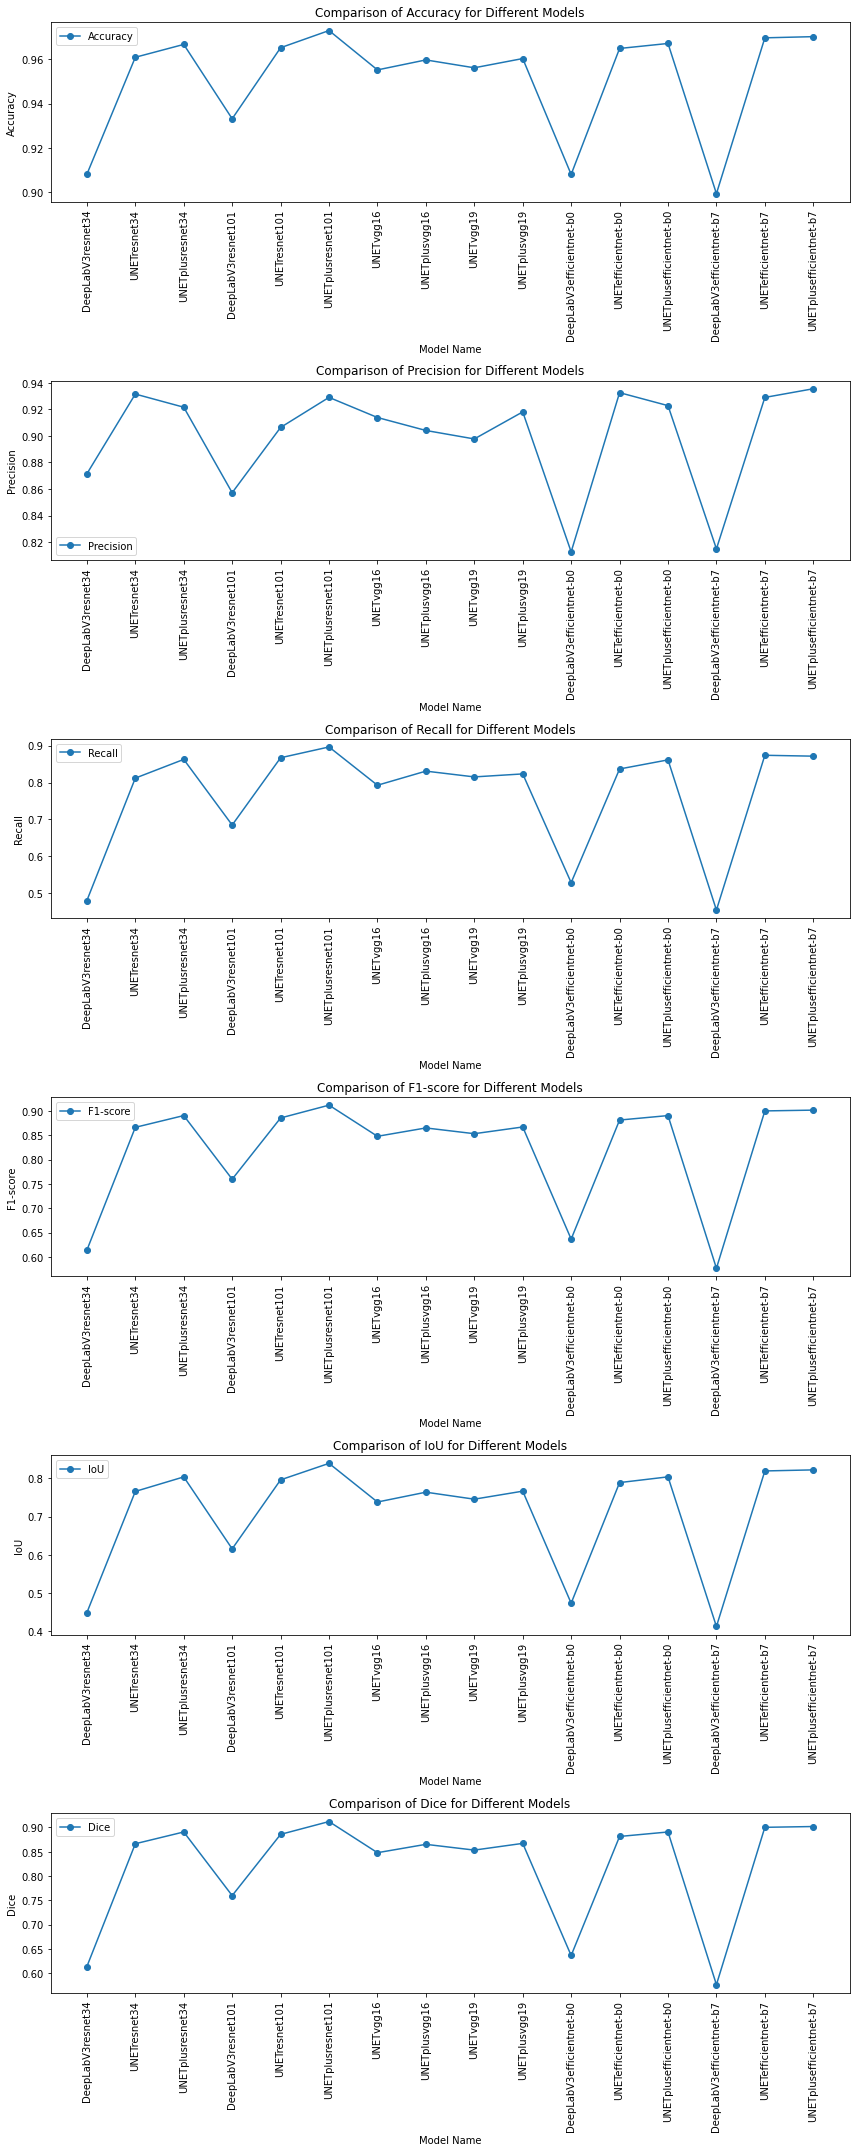

In [8]:
 # Plot evaluation results
encoder_names_with_vit = trained_models.keys() 
print(encoder_names_with_vit)
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "IoU", "Dice"]

fig, axs = plt.subplots(len(metrics), 1, figsize=(12, 30))
for i, metric in enumerate(metrics):
    axs[i].plot(encoder_names_with_vit, [evaluation_results[name][metric] for name in encoder_names_with_vit], label=metric, marker='o')
    axs[i].legend()
    axs[i].set_xlabel("Model Name")
    axs[i].set_ylabel(metric)
    axs[i].set_title(f"Comparison of {metric} for Different Models")
    axs[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [9]:
best_metric = 'IoU'  # You can change this to IoU, F1-score, etc.

# Sort the models based on the best_metric in descending order
sorted_models = sorted(evaluation_results.items(), key=lambda x: x[1][best_metric], reverse=True)

# Get the best model name and its corresponding evaluation metrics
best_model_name, best_model_metrics = sorted_models[0]

print(f"Best model based on {best_metric}: {best_model_name}")
print(f"Evaluation metrics for the best model: {best_model_metrics}")


Best model based on IoU: UNETplusresnet101
Evaluation metrics for the best model: {'Accuracy': 0.9730960300990513, 'Precision': 0.9289775489808496, 'Recall': 0.8963638287577661, 'F1-score': 0.9122071505058884, 'IoU': 0.8391734521538917, 'Dice': 0.9122071505058883}


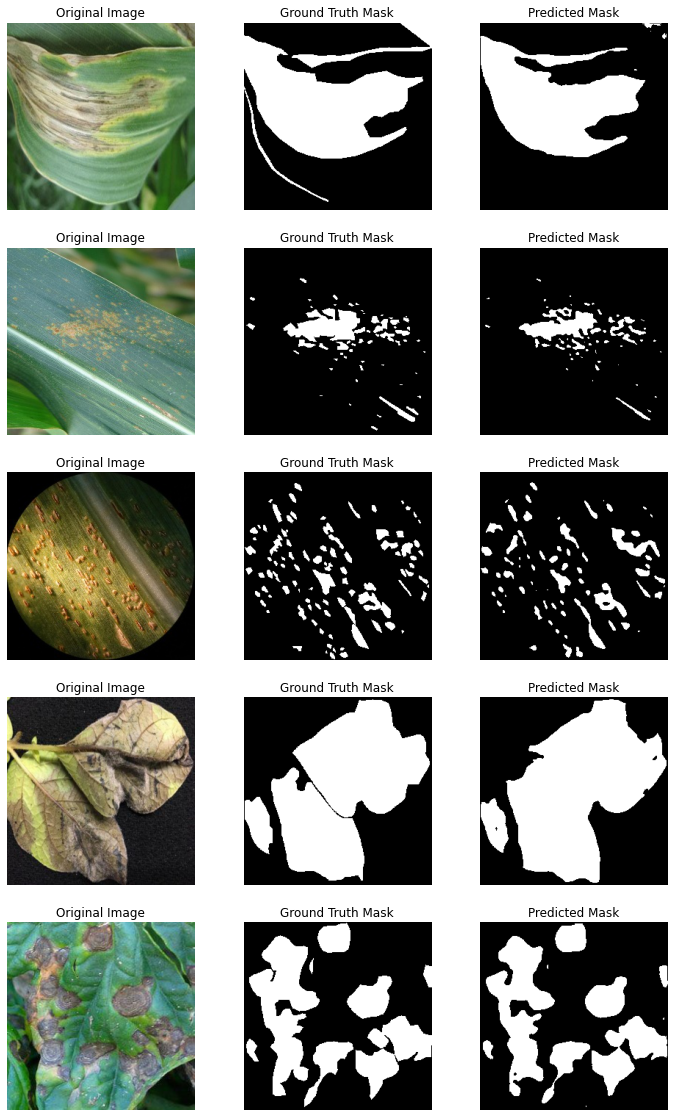

In [10]:
model=trained_models[best_model_name]
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        preds = torch.sigmoid(model(images))
        # preds = model(images)

        preds = (preds > threshold).float()
        masks = (masks > threshold).float()

num_images_to_plot = min(5, len(images))
fig, ax = plt.subplots(num_images_to_plot, 3, figsize=(12, num_images_to_plot*4))

for i in range(num_images_to_plot):
    ax[i, 0].imshow(tensor_to_image(images[i]))
    ax[i, 0].set_title("Original Image")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(tensor_to_mask(masks[i]), cmap="gray")
    ax[i, 1].set_title("Ground Truth Mask")
    ax[i, 1].axis("off")

    ax[i, 2].imshow(tensor_to_mask(preds[i]), cmap="gray")
    ax[i, 2].set_title("Predicted Mask")
    ax[i, 2].axis("off")

plt.show()